In [1]:
!pip install -U albumentations

     |████████████████████████████████| 102 kB 3.2 MB/s 
     |████████████████████████████████| 47.6 MB 36 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [2]:
%matplotlib inline

In [3]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR,OneCycleLR
import torch.optim as optim
from tqdm import tqdm


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import albumentations as A
from torch.utils.data import DataLoader, Dataset
from PIL import Image

In [5]:
import matplotlib.pyplot as plt
import numpy as np
!pip install torchsummary
from torchsummary import summary

### Augmentation

In [6]:
# EXPERIMENT horizontalflip_prob increased to 0.3 from 0.2, rotate_limit to 20 from 15
def data_albumentations(horizontalflip_prob = 0.3,
                        rotate_limit = 15,
                        shiftscalerotate_prob = 0.2,
                        num_holes = 1,
                        cutout_prob = 0.5):
    # Calculate mean and std deviation for cifar dataset
    mean,std = calculate_mean_std()
    
    # Train Phase transformations
    train_transforms = A.Compose([A.HorizontalFlip(p=horizontalflip_prob),
                                  A.GaussNoise(p=0.1),
                                  A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=rotate_limit, p=shiftscalerotate_prob),
                                  A.CoarseDropout(max_holes=num_holes,min_holes = 1, max_height=16, max_width=16, 
                                  p=cutout_prob,fill_value=tuple([x * 255.0 for x in mean]),
                                  min_height=16, min_width=16),
                                  A.ColorJitter(p=0.25,brightness=0.3, contrast=0.3, saturation=0.30, hue=0.2),
                                  A.ToGray(p=0.2),
                                  A.Normalize(mean=mean, std=std,always_apply=True),
                                  ToTensorV2()
                                ])

    # Test Phase transformations
    test_transforms = A.Compose([A.Normalize(mean=mean, std=std, always_apply=True),
                                 ToTensorV2()])

    return lambda img:train_transforms(image=np.array(img))["image"],lambda img:test_transforms(image=np.array(img))["image"]

### Helper functions

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [8]:
def plot_metrics(exp_metrics):
    sns.set(font_scale=1)
    plt.rcParams["figure.figsize"] = (25,6)
    train_accuracy,train_losses,test_accuracy,test_losses  = exp_metrics
    
    # Plot the learning curve.
    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.plot(np.array(test_losses), 'b', label="Validation Loss")
    
    # Label the plot.
    ax1.set_title("Validation Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    
    ax2.plot(np.array(test_accuracy), 'b', label="Validation Accuracy")
    
    # Label the plot.
    ax2.set_title("Validation Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend()
    
    plt.show()

In [9]:
def calculate_mean_std():
  train_transform = transforms.Compose([transforms.ToTensor()])
  train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
  mean = train_set.data.mean(axis=(0,1,2))/255
  std = train_set.data.std(axis=(0,1,2))/255
  return mean, std

In [10]:
def set_seed(seed,cuda_available):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda_available:
        torch.cuda.manual_seed(seed)

In [11]:
def model_summary(model, input_size=(3, 32, 32)):
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  print(model)
  summary(model,input_size)

In [12]:
def class_level_accuracy(model, test_loader, device, 
                         class_correct = list(0. for i in range(10)),
                         class_total = list(0. for i in range(10))):
  # specify the image classes
  classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
             'dog', 'frog', 'horse', 'ship', 'truck']
  with torch.no_grad():
    for data in test_loader:
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)
      c = (predicted == labels).squeeze()
      for i in range(4):
        label = labels[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1
  for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

In [13]:
def wrong_predictions(test_loader,
                      use_cuda,
                      model):
        class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        
        wrong_images=[]
        wrong_label=[]
        correct_label=[]
        with torch.no_grad():
            for data, target in test_loader:
                if use_cuda:
                  data = data.cuda()
                  target = target.cuda()

                output = model(data)        
                pred = output.argmax(dim=1, keepdim=True).squeeze()  # get the index of the max log-probability
                wrong_pred = (pred.eq(target.view_as(pred)) == False)
                wrong_images.append(data[wrong_pred])
                wrong_label.append(pred[wrong_pred])
                correct_label.append(target.view_as(pred)[wrong_pred])  
      
                wrong_predictions = list(zip(torch.cat(wrong_images),torch.cat(wrong_label),torch.cat(correct_label)))    
            print(f'Total wrong predictions are {len(wrong_predictions)}')
      
      
            fig = plt.figure(figsize=(18,20))
            fig.tight_layout()
            # mean,std = helper.calculate_mean_std("CIFAR10")
            for i, (img, pred, correct) in enumerate(wrong_predictions[:10]):
                  img, pred, target = img.cpu().numpy(), pred.cpu(), correct.cpu()
        
                  #mean = torch.FloatTensor(mean).view( 3, 1, 1).expand_as(img).cpu()
                  #std = torch.FloatTensor(std).view( 3, 1, 1).expand_as(img).cpu()
                  #img = img.mul(std).add(mean)
                  #img=img.numpy()
                  
                  img = np.transpose(img, (1, 2, 0)) / 2 + 0.5
                  ax = fig.add_subplot(5, 5, i+1)
                  ax.axis('off')
                  ax.set_title(f'\nactual : {class_names[target.item()]}\npredicted : {class_names[pred.item()]}',fontsize=10)  
                  ax.imshow(img)  
          
            plt.show()

In [14]:
def train(model, device, train_loader, optimizer, epoch,train_acc,train_loss,lambda_l1,scheduler,criterion,lrs,grad_clip=None):

  model.train()
  pbar = tqdm(train_loader)
  
  correct = 0
  processed = 0
  
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    
    #L1 Regularization
    if lambda_l1 > 0:
      l1 = 0
      for p in model.parameters():
        l1 = l1 + p.abs().sum()
      loss = loss + lambda_l1*l1

    train_loss.append(loss.data.cpu().numpy().item())

    # Backpropagation
    loss.backward()
    
    # Gradient clipping
    if grad_clip: 
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)
        
    optimizer.step()
    scheduler.step()
    lrs.append(get_lr(optimizer))

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} LR={lrs[-1]:0.5f} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

In [15]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [16]:
def visualize_sample_test_result(model,test_loader,use_cuda):
  # obtain one batch of test images
  dataiter = iter(test_loader)
  images, labels = dataiter.next()
  images.numpy()
  class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  # move model inputs to cuda, if GPU available
  if use_cuda:
    images = images.cuda()

  # get sample outputs
  output = model(images)
  # convert output probabilities to predicted class
  _, preds_tensor = torch.max(output, 1)
  preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
 # plot the images in the batch, along with predicted and true labels
  fig = plt.figure(figsize=(25, 4))
  for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx].cpu())
    ax.set_title("{} ({})".format(class_names[preds[idx]], class_names[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))   

## Data Loader

In [17]:
class Cifar10DataLoader:
    def __init__(self,batchsize=256):
      self.batch_size = batchsize
      self.num_workers = 2
      self.pin_memory = True

      train_transforms, test_transforms = data_albumentations()

      trainset = datasets.CIFAR10(root='./data', train=True,
                                  download=True, transform=train_transforms)
      
      testset  = datasets.CIFAR10(root='./data', train=False,
                                  download=True, transform=test_transforms)
      
      self.train_loader = torch.utils.data.DataLoader(trainset,
                                                      batch_size = self.batch_size,
                                                      shuffle = True,
                                                      num_workers = self.num_workers,
                                                      pin_memory = self.pin_memory)
      
      self.test_loader = torch.utils.data.DataLoader(testset, 
                                                      batch_size = self.batch_size,
                                                      shuffle = True,
                                                      num_workers = self.num_workers,
                                                      pin_memory = self.pin_memory)

## Training Functions

In [18]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [19]:
def train(model, device, train_loader, optimizer, epoch,train_acc,train_loss,lambda_l1,scheduler,criterion,lrs,grad_clip=None):

  model.train()
  pbar = tqdm(train_loader)
  
  correct = 0
  processed = 0
  
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    
    #L1 Regularization
    if lambda_l1 > 0:
      l1 = 0
      for p in model.parameters():
        l1 = l1 + p.abs().sum()
      loss = loss + lambda_l1*l1

    train_loss.append(loss.data.cpu().numpy().item())

    # Backpropagation
    loss.backward()
    
    # Gradient clipping
    if grad_clip: 
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)
        
    optimizer.step()
    scheduler.step()
    lrs.append(get_lr(optimizer))

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} LR={lrs[-1]:0.5f} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

In [20]:
def test(model, device, test_loader,test_acc,test_losses,criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [29]:
import torch.nn as nn
import torch.nn.functional as F


import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self,dropout):
        super(Net, self).__init__()
        
        ## Convolution Block1
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 38, 3, padding=1, bias = False),  # Input: 32x32x3 | Output: 32x32x32 | RF: 3x3
            nn.ReLU(),
            nn.BatchNorm2d(38),
            nn.Dropout2d(dropout),

            nn.Conv2d(38, 64, 3, padding=1, bias = False), # Input: 32x32x32 | Output: 32x32x64 | RF: 5x5
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(dropout)
        )
        
        ## Transition Block1
        self.trans1 = nn.Sequential(
            nn.Conv2d(64, 32,1, stride=2), # Input: 32x32x64 | Output: 16x16x32 | RF: 5x5
            nn.ReLU(),
        )

        ## Convolution Block2
        self.conv2 =  nn.Sequential(
            nn.Conv2d(32, 32, 3,  padding=1, bias = False), # Input: 16x16x32 | Output: 16x16x32 | RF: 9x9
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(dropout),

            ## Depthwise Seperable Convolution1
            nn.Conv2d(32,32, 3,  padding=1,groups=32 ,bias = False),  # Input: 16x16x32 | Output: 16x16x32 | RF: 13x13
            nn.Conv2d(32, 64, 1, padding=1, bias = False),   # Input: 16x16x32 | Output: 18x18x64 | RF: 13x13
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(dropout),
        )
        
        #Transition Block2
        self.trans2 = nn.Sequential(

            nn.Conv2d(64, 32, 1, stride=2), # Input: 18x18x32 | Output: 9x9x64 | RF: 13x13
            nn.ReLU()
        )

        #Convolution Block3
        self.conv3 = nn.Sequential(
            
            ## Dilation Block
            nn.Conv2d(32, 64, 3,  padding=1, bias = False,dilation=2), # Input: 9x9x64 | Output: 7x7x64 | RF: 29x29
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(dropout),

            nn.Conv2d(64, 64, 3,  padding=1, bias = False),  # Input: 7x7x64| Output: 7x7x64 | RF: 45x45
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(dropout),
        )

        #Transition Block3
        self.trans3 = nn.Sequential(

            nn.Conv2d(64, 16, 1, stride=2), # Input: 7x7x64| Output: 4x4x16 | RF: 61x61
            nn.ReLU()
        )

        #Convolution Block4        
        self.conv4 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1, bias = False), # Input: 4x4x16 | Output: 4x4x32 | RF: 93x93
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(dropout),

            ## Depthwise seperable Convolution2
            nn.Conv2d(32,32, 3,  padding=1,groups=32 ,bias = False),# Input: 4x4x16 | Output: 4x4x32 | RF: 125x125
            nn.Conv2d(32, 10, 1, padding=1, bias = False),          # Input: 4x4x32| Output: 6x6x10 | RF: 125x125
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout2d(dropout),
        )

        ## Output Block
        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
        ) 


    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(x)

        x = self.conv2(x) 
        x = self.trans2(x) 

        x = self.conv3(x) 
        x = self.trans3(x)

        x = self.conv4(x)
        x = self.gap(x)

        x = x.view(-1,10)
        return F.log_softmax(x,dim=1)

## Run Experiments

In [30]:
def run_experiments(device,
                    dataset,
                    epochs,
                    model):
  l1_factor = 0
  l2_factor = 0.0001
  # optim_type = optim.Adam
  criterion = nn.CrossEntropyLoss()
  # opt_func = optim.Adam
  lr = 0.01
  grad_clip = 0.1
  train_losses = []
  test_losses = []
  train_accuracy = []
  test_accuracy = []
  lrs=[]

  model = model
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2_factor)
  scheduler = OneCycleLR(optimizer, max_lr=lr,epochs=epochs,steps_per_epoch=len(dataset.train_loader))

  for epoch in range(1, epochs + 1):
    print(f'Epoch {epoch}:')
    train(model, device, dataset.train_loader, optimizer,epoch, train_accuracy, train_losses, l1_factor,scheduler,criterion,lrs,grad_clip)
    test(model, device, dataset.test_loader,test_accuracy,test_losses,criterion)
  
  return (train_accuracy,train_losses,test_accuracy,test_losses),model


In [31]:
def save_experiment(self,model, experiment_name='cifar10-adv'):
  print(f"Saving the model for {experiment_name}")
  torch.save(model, './saved_models/{}.pt'.format(experiment_name))

## Training

In [32]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [33]:
cifar_dataset=Cifar10DataLoader()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


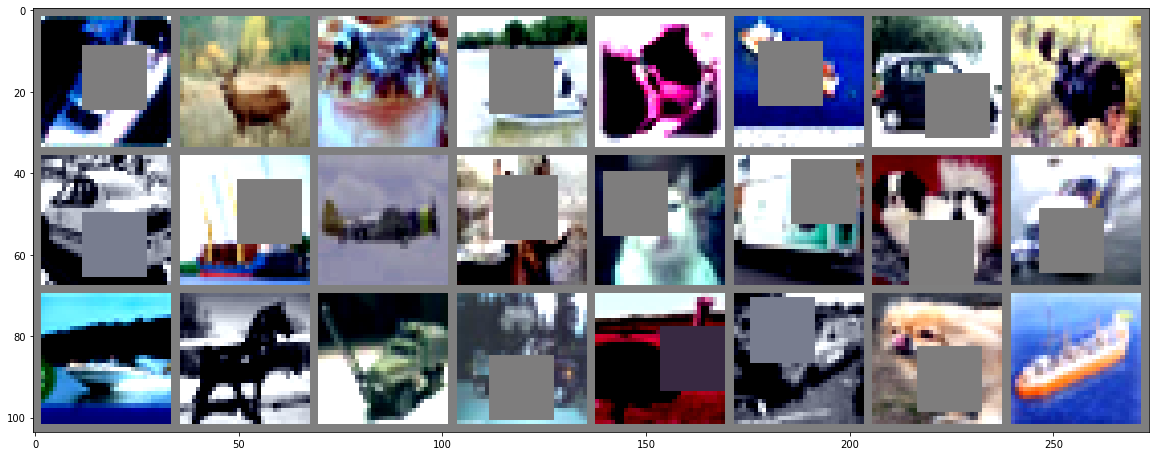

In [34]:
fig, ax = plt.subplots(figsize=(20, 20))
# get some random training images
dataiter = iter(cifar_dataset.train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:24]))

In [35]:
experiment_name = "cifar10-training"
epochs = 80
dropout = 0.05 ## increased from .01 - EXPERIMENT
model = Net(dropout).to(device)

In [36]:
model_summary(model)

Net(
  (conv1): Sequential(
    (0): Conv2d(3, 38, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(38, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.05, inplace=False)
    (4): Conv2d(38, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout2d(p=0.05, inplace=False)
  )
  (trans1): Sequential(
    (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(2, 2))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.05, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (5): Conv2d(32, 64, kernel_size=(1, 1),

In [37]:
exp_metrics={}

exp_metrics[experiment_name],model = run_experiments(device,
                                                       cifar_dataset,
                                                       epochs,
                                                       model)

# save_experiment(model,experiment_name)

Epoch 1:


Loss=2.022407293319702 Batch_id=195 LR=0.00044 Accuracy=27.30: 100%|██████████| 196/196 [00:28<00:00,  6.95it/s]



Test set: Average loss: 0.0068, Accuracy: 4325/10000 (43.25%)

Epoch 2:


Loss=1.8828649520874023 Batch_id=195 LR=0.00056 Accuracy=38.05: 100%|██████████| 196/196 [00:28<00:00,  6.94it/s]



Test set: Average loss: 0.0061, Accuracy: 5008/10000 (50.08%)

Epoch 3:


Loss=1.5948963165283203 Batch_id=195 LR=0.00077 Accuracy=43.65: 100%|██████████| 196/196 [00:28<00:00,  6.90it/s]



Test set: Average loss: 0.0054, Accuracy: 5629/10000 (56.29%)

Epoch 4:


Loss=1.4091318845748901 Batch_id=195 LR=0.00104 Accuracy=48.43: 100%|██████████| 196/196 [00:28<00:00,  6.83it/s]



Test set: Average loss: 0.0049, Accuracy: 6042/10000 (60.42%)

Epoch 5:


Loss=1.4812242984771729 Batch_id=195 LR=0.00139 Accuracy=52.10: 100%|██████████| 196/196 [00:28<00:00,  6.86it/s]



Test set: Average loss: 0.0047, Accuracy: 6138/10000 (61.38%)

Epoch 6:


Loss=1.353073000907898 Batch_id=195 LR=0.00181 Accuracy=55.32: 100%|██████████| 196/196 [00:28<00:00,  6.91it/s]



Test set: Average loss: 0.0042, Accuracy: 6532/10000 (65.32%)

Epoch 7:


Loss=1.367403268814087 Batch_id=195 LR=0.00228 Accuracy=57.62: 100%|██████████| 196/196 [00:28<00:00,  6.95it/s]



Test set: Average loss: 0.0038, Accuracy: 6813/10000 (68.13%)

Epoch 8:


Loss=1.0015294551849365 Batch_id=195 LR=0.00280 Accuracy=59.03: 100%|██████████| 196/196 [00:28<00:00,  6.94it/s]



Test set: Average loss: 0.0035, Accuracy: 7170/10000 (71.70%)

Epoch 9:


Loss=1.2820314168930054 Batch_id=195 LR=0.00336 Accuracy=60.82: 100%|██████████| 196/196 [00:28<00:00,  6.98it/s]



Test set: Average loss: 0.0035, Accuracy: 7093/10000 (70.93%)

Epoch 10:


Loss=1.2598626613616943 Batch_id=195 LR=0.00396 Accuracy=61.92: 100%|██████████| 196/196 [00:28<00:00,  6.93it/s]



Test set: Average loss: 0.0033, Accuracy: 7181/10000 (71.81%)

Epoch 11:


Loss=1.0537813901901245 Batch_id=195 LR=0.00457 Accuracy=62.57: 100%|██████████| 196/196 [00:28<00:00,  6.94it/s]



Test set: Average loss: 0.0037, Accuracy: 6884/10000 (68.84%)

Epoch 12:


Loss=1.2256414890289307 Batch_id=195 LR=0.00520 Accuracy=63.05: 100%|██████████| 196/196 [00:28<00:00,  6.99it/s]



Test set: Average loss: 0.0035, Accuracy: 6988/10000 (69.88%)

Epoch 13:


Loss=0.9510486721992493 Batch_id=195 LR=0.00583 Accuracy=63.46: 100%|██████████| 196/196 [00:28<00:00,  6.91it/s]



Test set: Average loss: 0.0034, Accuracy: 7133/10000 (71.33%)

Epoch 14:


Loss=0.9048405885696411 Batch_id=195 LR=0.00644 Accuracy=63.95: 100%|██████████| 196/196 [00:27<00:00,  7.04it/s]



Test set: Average loss: 0.0031, Accuracy: 7376/10000 (73.76%)

Epoch 15:


Loss=1.0331594944000244 Batch_id=195 LR=0.00704 Accuracy=64.53: 100%|██████████| 196/196 [00:27<00:00,  7.02it/s]



Test set: Average loss: 0.0030, Accuracy: 7504/10000 (75.04%)

Epoch 16:


Loss=1.1701607704162598 Batch_id=195 LR=0.00760 Accuracy=65.05: 100%|██████████| 196/196 [00:27<00:00,  7.01it/s]



Test set: Average loss: 0.0029, Accuracy: 7519/10000 (75.19%)

Epoch 17:


Loss=0.8848732113838196 Batch_id=195 LR=0.00812 Accuracy=65.18: 100%|██████████| 196/196 [00:28<00:00,  6.94it/s]



Test set: Average loss: 0.0038, Accuracy: 6860/10000 (68.60%)

Epoch 18:


Loss=1.3084214925765991 Batch_id=195 LR=0.00860 Accuracy=65.60: 100%|██████████| 196/196 [00:28<00:00,  6.90it/s]



Test set: Average loss: 0.0028, Accuracy: 7576/10000 (75.76%)

Epoch 19:


Loss=0.9107774496078491 Batch_id=195 LR=0.00901 Accuracy=65.89: 100%|██████████| 196/196 [00:28<00:00,  6.95it/s]



Test set: Average loss: 0.0037, Accuracy: 7020/10000 (70.20%)

Epoch 20:


Loss=0.919036865234375 Batch_id=195 LR=0.00936 Accuracy=65.98: 100%|██████████| 196/196 [00:28<00:00,  6.96it/s]



Test set: Average loss: 0.0028, Accuracy: 7629/10000 (76.29%)

Epoch 21:


Loss=0.971285343170166 Batch_id=195 LR=0.00964 Accuracy=65.97: 100%|██████████| 196/196 [00:28<00:00,  6.95it/s]



Test set: Average loss: 0.0030, Accuracy: 7597/10000 (75.97%)

Epoch 22:


Loss=0.7142541408538818 Batch_id=195 LR=0.00984 Accuracy=66.54: 100%|██████████| 196/196 [00:28<00:00,  6.88it/s]



Test set: Average loss: 0.0033, Accuracy: 7294/10000 (72.94%)

Epoch 23:


Loss=0.9512278437614441 Batch_id=195 LR=0.00996 Accuracy=66.32: 100%|██████████| 196/196 [00:28<00:00,  6.92it/s]



Test set: Average loss: 0.0029, Accuracy: 7569/10000 (75.69%)

Epoch 24:


Loss=1.0969278812408447 Batch_id=195 LR=0.01000 Accuracy=66.54: 100%|██████████| 196/196 [00:28<00:00,  6.94it/s]



Test set: Average loss: 0.0031, Accuracy: 7415/10000 (74.15%)

Epoch 25:


Loss=0.9239552617073059 Batch_id=195 LR=0.00999 Accuracy=66.84: 100%|██████████| 196/196 [00:28<00:00,  6.98it/s]



Test set: Average loss: 0.0027, Accuracy: 7735/10000 (77.35%)

Epoch 26:


Loss=1.1105310916900635 Batch_id=195 LR=0.00997 Accuracy=66.63: 100%|██████████| 196/196 [00:28<00:00,  6.99it/s]



Test set: Average loss: 0.0028, Accuracy: 7549/10000 (75.49%)

Epoch 27:


Loss=0.9232953786849976 Batch_id=195 LR=0.00993 Accuracy=67.13: 100%|██████████| 196/196 [00:28<00:00,  6.92it/s]



Test set: Average loss: 0.0027, Accuracy: 7720/10000 (77.20%)

Epoch 28:


Loss=1.1502974033355713 Batch_id=195 LR=0.00987 Accuracy=67.35: 100%|██████████| 196/196 [00:28<00:00,  6.98it/s]



Test set: Average loss: 0.0029, Accuracy: 7554/10000 (75.54%)

Epoch 29:


Loss=0.9359464645385742 Batch_id=195 LR=0.00980 Accuracy=67.48: 100%|██████████| 196/196 [00:28<00:00,  6.88it/s]



Test set: Average loss: 0.0031, Accuracy: 7443/10000 (74.43%)

Epoch 30:


Loss=0.9463990330696106 Batch_id=195 LR=0.00972 Accuracy=67.27: 100%|██████████| 196/196 [00:28<00:00,  6.85it/s]



Test set: Average loss: 0.0028, Accuracy: 7708/10000 (77.08%)

Epoch 31:


Loss=1.0831410884857178 Batch_id=195 LR=0.00962 Accuracy=67.52: 100%|██████████| 196/196 [00:28<00:00,  6.93it/s]



Test set: Average loss: 0.0028, Accuracy: 7539/10000 (75.39%)

Epoch 32:


Loss=1.1921014785766602 Batch_id=195 LR=0.00950 Accuracy=67.57: 100%|██████████| 196/196 [00:28<00:00,  6.89it/s]



Test set: Average loss: 0.0026, Accuracy: 7809/10000 (78.09%)

Epoch 33:


Loss=0.9214057922363281 Batch_id=195 LR=0.00938 Accuracy=67.74: 100%|██████████| 196/196 [00:28<00:00,  6.90it/s]



Test set: Average loss: 0.0025, Accuracy: 7811/10000 (78.11%)

Epoch 34:


Loss=1.0659615993499756 Batch_id=195 LR=0.00923 Accuracy=67.75: 100%|██████████| 196/196 [00:28<00:00,  6.96it/s]



Test set: Average loss: 0.0029, Accuracy: 7548/10000 (75.48%)

Epoch 35:


Loss=1.1434366703033447 Batch_id=195 LR=0.00908 Accuracy=67.76: 100%|██████████| 196/196 [00:28<00:00,  6.86it/s]



Test set: Average loss: 0.0028, Accuracy: 7629/10000 (76.29%)

Epoch 36:


Loss=0.933131217956543 Batch_id=195 LR=0.00891 Accuracy=67.66: 100%|██████████| 196/196 [00:28<00:00,  6.89it/s]



Test set: Average loss: 0.0027, Accuracy: 7703/10000 (77.03%)

Epoch 37:


Loss=0.8694039583206177 Batch_id=195 LR=0.00873 Accuracy=68.26: 100%|██████████| 196/196 [00:28<00:00,  6.89it/s]



Test set: Average loss: 0.0029, Accuracy: 7460/10000 (74.60%)

Epoch 38:


Loss=1.0209470987319946 Batch_id=195 LR=0.00853 Accuracy=68.12: 100%|██████████| 196/196 [00:28<00:00,  6.88it/s]



Test set: Average loss: 0.0028, Accuracy: 7556/10000 (75.56%)

Epoch 39:


Loss=0.959194540977478 Batch_id=195 LR=0.00833 Accuracy=68.63: 100%|██████████| 196/196 [00:28<00:00,  6.93it/s]



Test set: Average loss: 0.0028, Accuracy: 7599/10000 (75.99%)

Epoch 40:


Loss=1.3356534242630005 Batch_id=195 LR=0.00812 Accuracy=68.53: 100%|██████████| 196/196 [00:28<00:00,  6.85it/s]



Test set: Average loss: 0.0026, Accuracy: 7756/10000 (77.56%)

Epoch 41:


Loss=1.1186496019363403 Batch_id=195 LR=0.00789 Accuracy=68.53: 100%|██████████| 196/196 [00:28<00:00,  6.87it/s]



Test set: Average loss: 0.0026, Accuracy: 7747/10000 (77.47%)

Epoch 42:


Loss=0.9227995872497559 Batch_id=195 LR=0.00766 Accuracy=69.08: 100%|██████████| 196/196 [00:28<00:00,  6.84it/s]



Test set: Average loss: 0.0025, Accuracy: 7836/10000 (78.36%)

Epoch 43:


Loss=1.108260989189148 Batch_id=195 LR=0.00742 Accuracy=69.13: 100%|██████████| 196/196 [00:28<00:00,  6.80it/s]



Test set: Average loss: 0.0025, Accuracy: 7853/10000 (78.53%)

Epoch 44:


Loss=0.9655777215957642 Batch_id=195 LR=0.00717 Accuracy=69.54: 100%|██████████| 196/196 [00:28<00:00,  6.78it/s]



Test set: Average loss: 0.0025, Accuracy: 7873/10000 (78.73%)

Epoch 45:


Loss=0.6634911298751831 Batch_id=195 LR=0.00691 Accuracy=69.38: 100%|██████████| 196/196 [00:28<00:00,  6.88it/s]



Test set: Average loss: 0.0025, Accuracy: 7919/10000 (79.19%)

Epoch 46:


Loss=1.0891649723052979 Batch_id=195 LR=0.00665 Accuracy=69.75: 100%|██████████| 196/196 [00:28<00:00,  6.84it/s]



Test set: Average loss: 0.0025, Accuracy: 7898/10000 (78.98%)

Epoch 47:


Loss=0.7875875234603882 Batch_id=195 LR=0.00638 Accuracy=70.21: 100%|██████████| 196/196 [00:28<00:00,  6.82it/s]



Test set: Average loss: 0.0025, Accuracy: 7896/10000 (78.96%)

Epoch 48:


Loss=0.9591058492660522 Batch_id=195 LR=0.00611 Accuracy=70.54: 100%|██████████| 196/196 [00:28<00:00,  6.80it/s]



Test set: Average loss: 0.0024, Accuracy: 8048/10000 (80.48%)

Epoch 49:


Loss=0.7724288105964661 Batch_id=195 LR=0.00584 Accuracy=70.52: 100%|██████████| 196/196 [00:28<00:00,  6.91it/s]



Test set: Average loss: 0.0022, Accuracy: 8100/10000 (81.00%)

Epoch 50:


Loss=0.7358719110488892 Batch_id=195 LR=0.00556 Accuracy=70.56: 100%|██████████| 196/196 [00:28<00:00,  6.83it/s]



Test set: Average loss: 0.0024, Accuracy: 7979/10000 (79.79%)

Epoch 51:


Loss=0.8969652056694031 Batch_id=195 LR=0.00528 Accuracy=70.72: 100%|██████████| 196/196 [00:28<00:00,  6.81it/s]



Test set: Average loss: 0.0023, Accuracy: 8003/10000 (80.03%)

Epoch 52:


Loss=0.836993396282196 Batch_id=195 LR=0.00500 Accuracy=71.40: 100%|██████████| 196/196 [00:28<00:00,  6.86it/s]



Test set: Average loss: 0.0023, Accuracy: 8010/10000 (80.10%)

Epoch 53:


Loss=0.7243013381958008 Batch_id=195 LR=0.00472 Accuracy=71.49: 100%|██████████| 196/196 [00:28<00:00,  6.78it/s]



Test set: Average loss: 0.0022, Accuracy: 8069/10000 (80.69%)

Epoch 54:


Loss=0.7660061717033386 Batch_id=195 LR=0.00444 Accuracy=71.75: 100%|██████████| 196/196 [00:28<00:00,  6.89it/s]



Test set: Average loss: 0.0024, Accuracy: 8008/10000 (80.08%)

Epoch 55:


Loss=0.9809008836746216 Batch_id=195 LR=0.00416 Accuracy=72.04: 100%|██████████| 196/196 [00:28<00:00,  6.87it/s]



Test set: Average loss: 0.0023, Accuracy: 8068/10000 (80.68%)

Epoch 56:


Loss=0.7424259781837463 Batch_id=195 LR=0.00389 Accuracy=72.34: 100%|██████████| 196/196 [00:28<00:00,  6.81it/s]



Test set: Average loss: 0.0022, Accuracy: 8111/10000 (81.11%)

Epoch 57:


Loss=1.016801118850708 Batch_id=195 LR=0.00361 Accuracy=72.54: 100%|██████████| 196/196 [00:29<00:00,  6.70it/s]



Test set: Average loss: 0.0021, Accuracy: 8235/10000 (82.35%)

Epoch 58:


Loss=0.7061943411827087 Batch_id=195 LR=0.00335 Accuracy=72.95: 100%|██████████| 196/196 [00:28<00:00,  6.80it/s]



Test set: Average loss: 0.0021, Accuracy: 8219/10000 (82.19%)

Epoch 59:


Loss=0.8745347261428833 Batch_id=195 LR=0.00309 Accuracy=73.20: 100%|██████████| 196/196 [00:28<00:00,  6.78it/s]



Test set: Average loss: 0.0022, Accuracy: 8212/10000 (82.12%)

Epoch 60:


Loss=0.8099256753921509 Batch_id=195 LR=0.00283 Accuracy=73.54: 100%|██████████| 196/196 [00:28<00:00,  6.87it/s]



Test set: Average loss: 0.0020, Accuracy: 8304/10000 (83.04%)

Epoch 61:


Loss=0.8480998873710632 Batch_id=195 LR=0.00258 Accuracy=73.58: 100%|██████████| 196/196 [00:29<00:00,  6.75it/s]



Test set: Average loss: 0.0020, Accuracy: 8284/10000 (82.84%)

Epoch 62:


Loss=0.7261093854904175 Batch_id=195 LR=0.00234 Accuracy=74.16: 100%|██████████| 196/196 [00:28<00:00,  6.85it/s]



Test set: Average loss: 0.0019, Accuracy: 8405/10000 (84.05%)

Epoch 63:


Loss=0.8243073225021362 Batch_id=195 LR=0.00211 Accuracy=74.71: 100%|██████████| 196/196 [00:28<00:00,  6.78it/s]



Test set: Average loss: 0.0019, Accuracy: 8389/10000 (83.89%)

Epoch 64:


Loss=0.6479948163032532 Batch_id=195 LR=0.00188 Accuracy=75.16: 100%|██████████| 196/196 [00:28<00:00,  6.82it/s]



Test set: Average loss: 0.0019, Accuracy: 8387/10000 (83.87%)

Epoch 65:


Loss=0.7121745347976685 Batch_id=195 LR=0.00167 Accuracy=75.49: 100%|██████████| 196/196 [00:28<00:00,  6.82it/s]



Test set: Average loss: 0.0018, Accuracy: 8450/10000 (84.50%)

Epoch 66:


Loss=0.8674308657646179 Batch_id=195 LR=0.00146 Accuracy=75.78: 100%|██████████| 196/196 [00:28<00:00,  6.83it/s]



Test set: Average loss: 0.0019, Accuracy: 8436/10000 (84.36%)

Epoch 67:


Loss=0.6801562905311584 Batch_id=195 LR=0.00127 Accuracy=76.14: 100%|██████████| 196/196 [00:28<00:00,  6.85it/s]



Test set: Average loss: 0.0018, Accuracy: 8513/10000 (85.13%)

Epoch 68:


Loss=0.6672330498695374 Batch_id=195 LR=0.00109 Accuracy=76.00: 100%|██████████| 196/196 [00:28<00:00,  6.89it/s]



Test set: Average loss: 0.0018, Accuracy: 8525/10000 (85.25%)

Epoch 69:


Loss=0.783539891242981 Batch_id=195 LR=0.00092 Accuracy=76.51: 100%|██████████| 196/196 [00:28<00:00,  6.85it/s]



Test set: Average loss: 0.0017, Accuracy: 8542/10000 (85.42%)

Epoch 70:


Loss=0.6793501377105713 Batch_id=195 LR=0.00077 Accuracy=76.70: 100%|██████████| 196/196 [00:28<00:00,  6.86it/s]



Test set: Average loss: 0.0017, Accuracy: 8542/10000 (85.42%)

Epoch 71:


Loss=0.5924854874610901 Batch_id=195 LR=0.00062 Accuracy=76.79: 100%|██████████| 196/196 [00:28<00:00,  6.82it/s]



Test set: Average loss: 0.0017, Accuracy: 8569/10000 (85.69%)

Epoch 72:


Loss=0.5590924620628357 Batch_id=195 LR=0.00049 Accuracy=77.34: 100%|██████████| 196/196 [00:28<00:00,  6.91it/s]



Test set: Average loss: 0.0018, Accuracy: 8559/10000 (85.59%)

Epoch 73:


Loss=0.9360953569412231 Batch_id=195 LR=0.00038 Accuracy=77.16: 100%|██████████| 196/196 [00:28<00:00,  6.85it/s]



Test set: Average loss: 0.0017, Accuracy: 8593/10000 (85.93%)

Epoch 74:


Loss=0.6578344702720642 Batch_id=195 LR=0.00028 Accuracy=77.16: 100%|██████████| 196/196 [00:28<00:00,  6.81it/s]



Test set: Average loss: 0.0017, Accuracy: 8584/10000 (85.84%)

Epoch 75:


Loss=0.5903981328010559 Batch_id=195 LR=0.00020 Accuracy=77.71: 100%|██████████| 196/196 [00:28<00:00,  6.80it/s]



Test set: Average loss: 0.0017, Accuracy: 8601/10000 (86.01%)

Epoch 76:


Loss=0.8037152290344238 Batch_id=195 LR=0.00013 Accuracy=77.61: 100%|██████████| 196/196 [00:29<00:00,  6.72it/s]



Test set: Average loss: 0.0017, Accuracy: 8606/10000 (86.06%)

Epoch 77:


Loss=0.7046481370925903 Batch_id=195 LR=0.00007 Accuracy=78.01: 100%|██████████| 196/196 [00:28<00:00,  6.79it/s]



Test set: Average loss: 0.0017, Accuracy: 8606/10000 (86.06%)

Epoch 78:


Loss=0.8595417737960815 Batch_id=195 LR=0.00003 Accuracy=78.02: 100%|██████████| 196/196 [00:29<00:00,  6.72it/s]



Test set: Average loss: 0.0017, Accuracy: 8622/10000 (86.22%)

Epoch 79:


Loss=0.5318413972854614 Batch_id=195 LR=0.00001 Accuracy=77.92: 100%|██████████| 196/196 [00:29<00:00,  6.76it/s]



Test set: Average loss: 0.0017, Accuracy: 8620/10000 (86.20%)

Epoch 80:


Loss=0.829922080039978 Batch_id=195 LR=0.00000 Accuracy=77.77: 100%|██████████| 196/196 [00:28<00:00,  6.80it/s]



Test set: Average loss: 0.0017, Accuracy: 8619/10000 (86.19%)



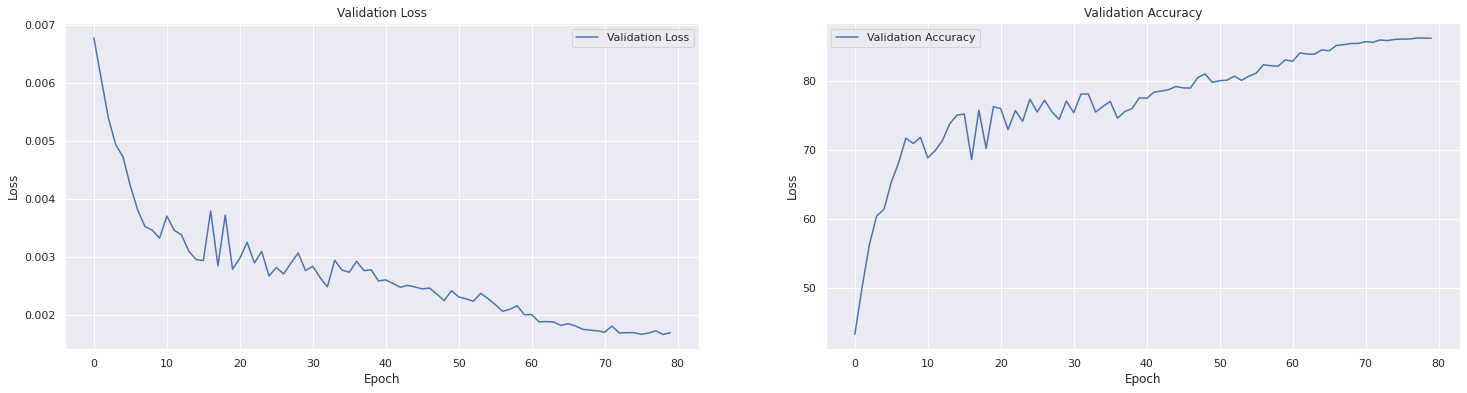

In [38]:
plot_metrics(exp_metrics[experiment_name])     

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total wrong predictions are 1381


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


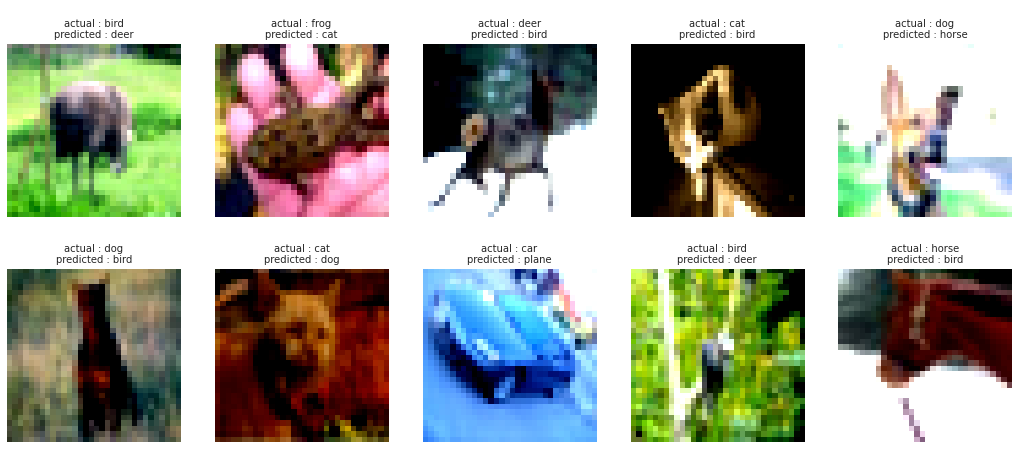

In [39]:
# model = torch.load(f'./saved_models/{experiment_name}.pt')
model.eval()
wrong_predictions(cifar_dataset.test_loader,
                  use_cuda,
                  model)

In [40]:
class_level_accuracy(model, cifar_dataset.test_loader, device)

Accuracy of airplane : 88 %
Accuracy of automobile : 92 %
Accuracy of  bird : 68 %
Accuracy of   cat : 83 %
Accuracy of  deer : 85 %
Accuracy of   dog : 70 %
Accuracy of  frog : 82 %
Accuracy of horse : 92 %
Accuracy of  ship : 95 %
Accuracy of truck : 85 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

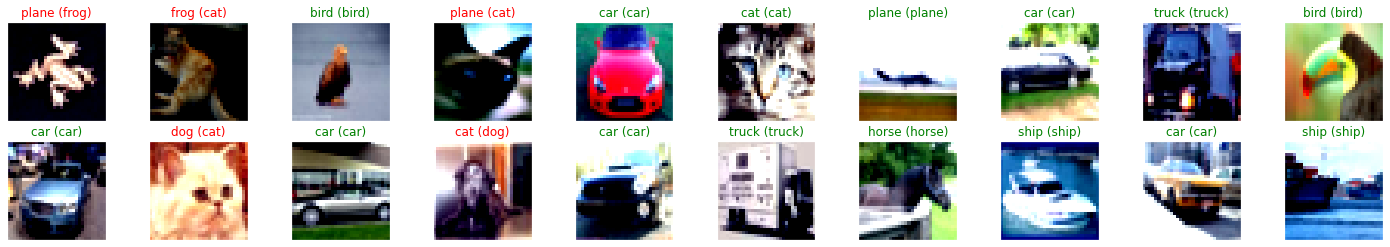

In [41]:
visualize_sample_test_result(model, 
                             cifar_dataset.test_loader,
                             use_cuda)

In [42]:
!pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=9bd25a974a7d4496cc45c4752c675e7dc7534d39fd69367f8bcb48d6df6d4d8e
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [43]:
model = model.to(device)

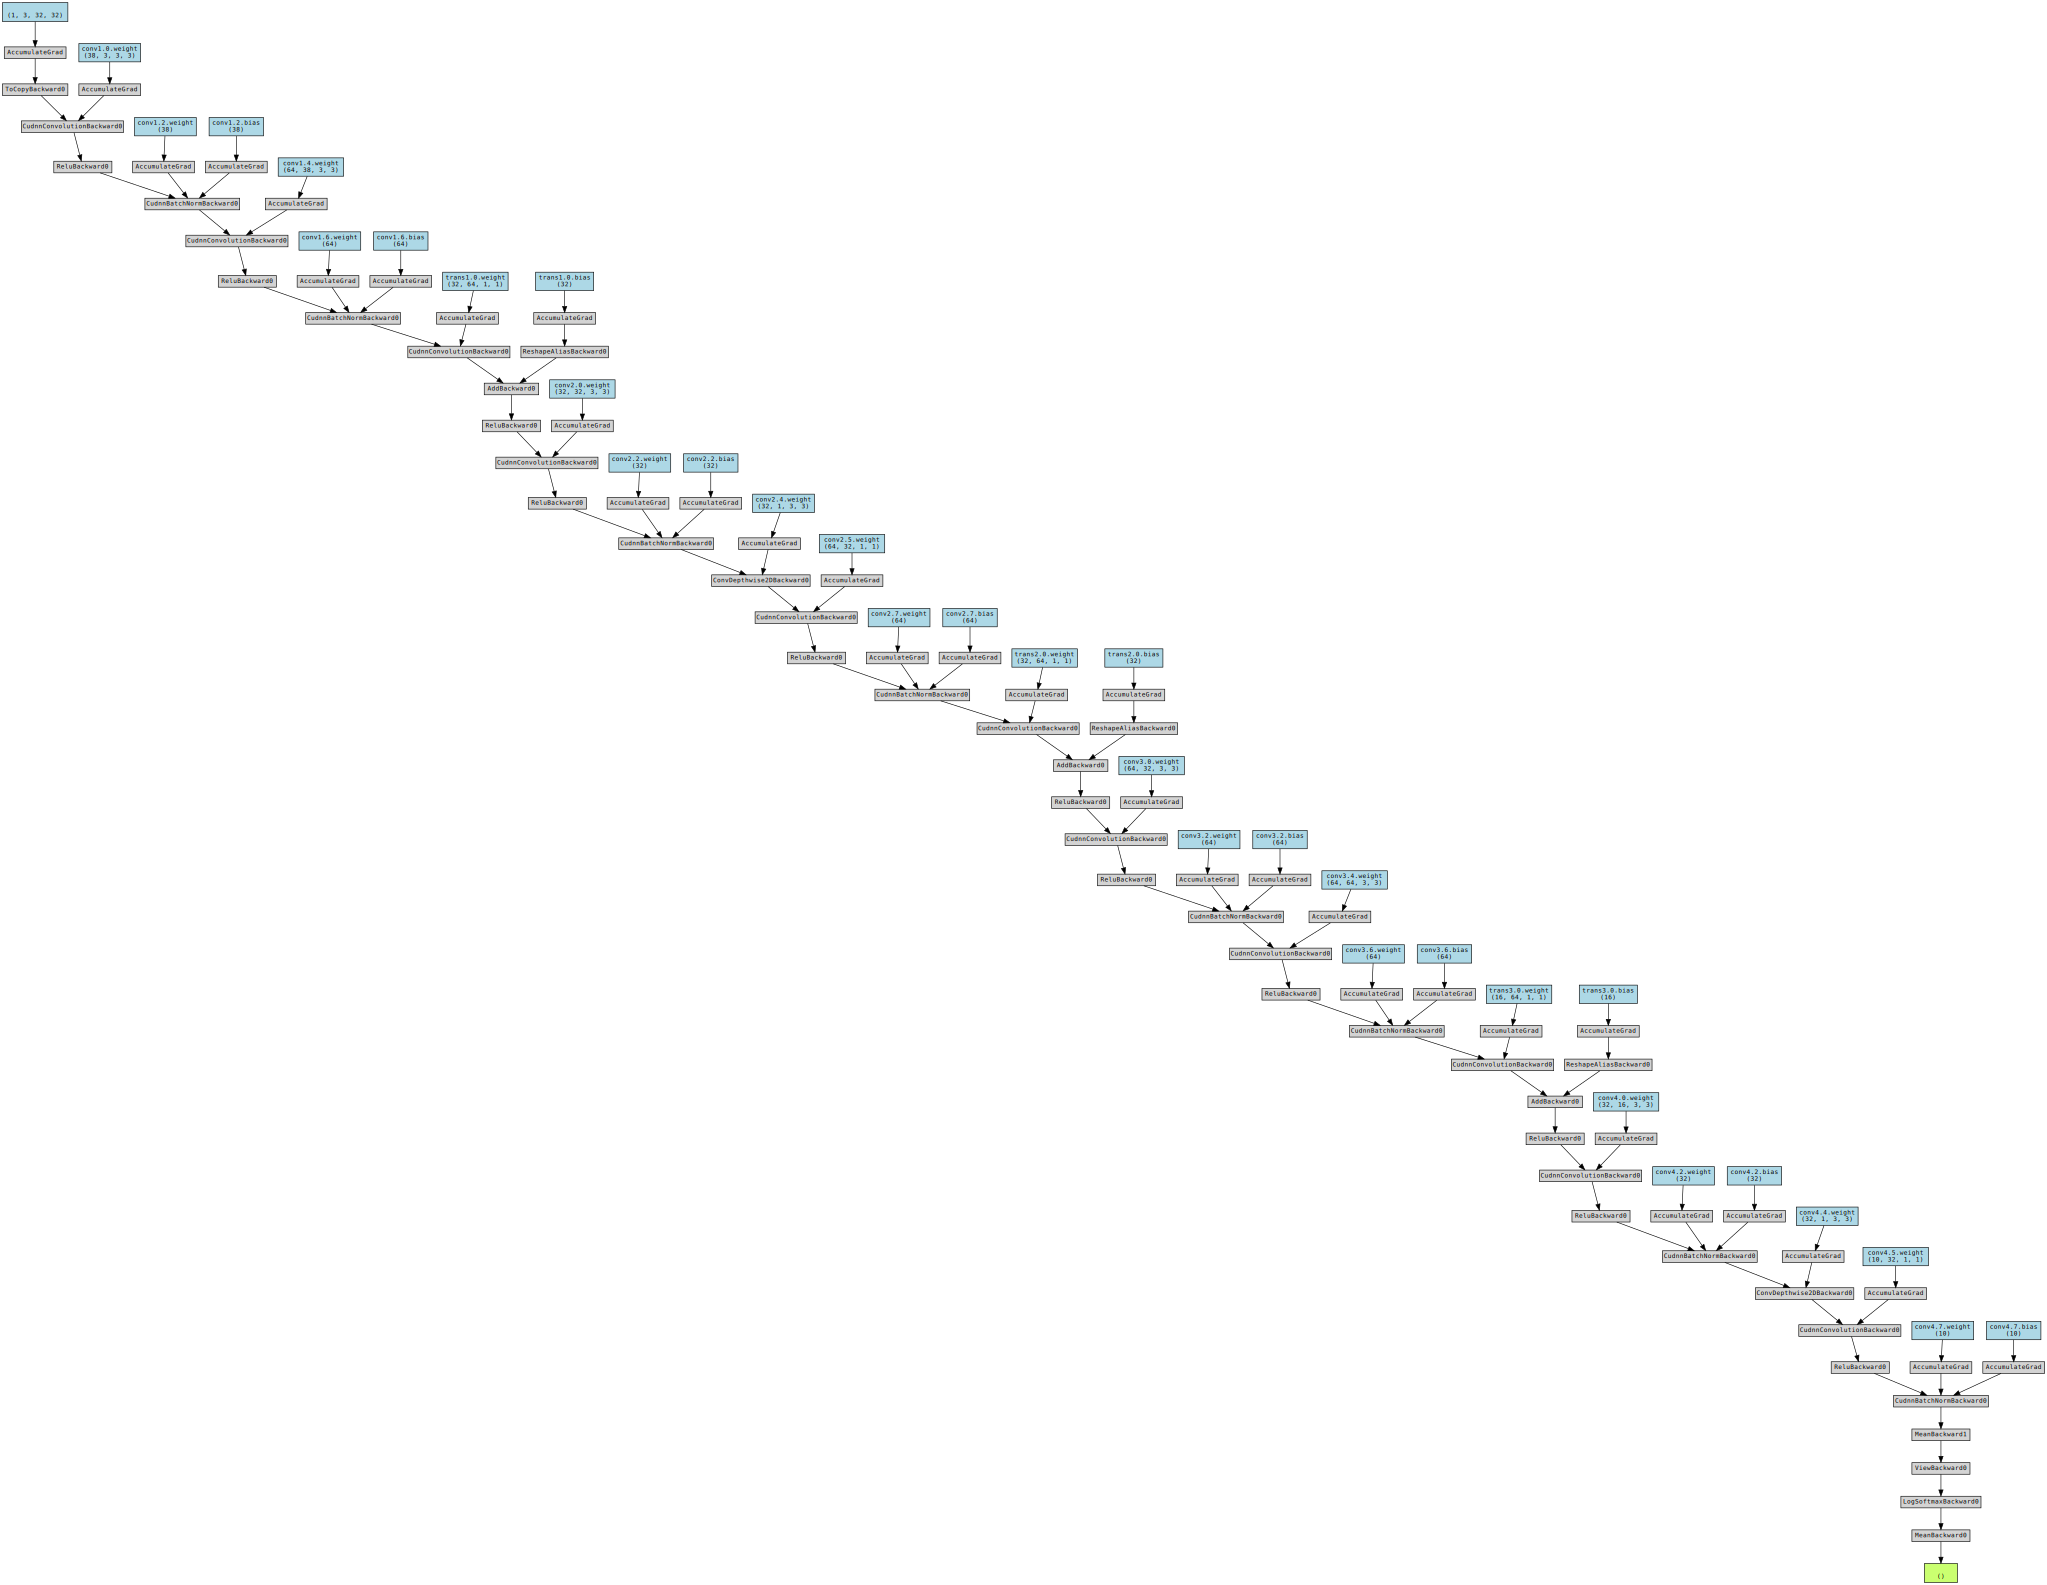

In [44]:
 from torchviz import make_dot
 x = torch.randn(1, 3, 32, 32).requires_grad_(True).cuda()
 y = model(x)   
 MyConvNetVis = make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))
 MyConvNetVis.format = "png"
 MyConvNetVis.directory = "data"
 MyConvNetVis.view()
 make_dot(y.mean(), params=dict(model.named_parameters()))
